![logo](../../../LogoLine_horizon_C3S.png)

# Spatial and temporal completeness of methane satellite observations for the analysis of extreme events related to large episodic releases

Production date: 23-04-2025

Produced by: CNR

## 🌍 Use case: Detecting extreme release of methane into the atmosphere

## ❓ Quality assessment question
* **Are methane satellite observations suitable for detecting atmospheric signals associated with extreme emission releases?**
* **How well, in terms of completeness, do Level 2 mid-tropospheric CH$_4$ columns capture the spatial variability of methane associated with large release events?**

Methane (CH$_4$) is the second most important anthropogenic greenhouse gas after carbon dioxide (CO$_2$), representing about 19% of the total radiative forcing by long-lived greenhouse gases [[1]](https://wmo.int/publication-series/wmo-greenhouse-gas-bulletin-no-19). Atmospheric CH$_4$ also adversely affects human health as a precursor of tropospheric ozone [[2]](https://doi.org/10.1073/pnas.0600201103). Thus, sudden large release of CH$_4$ into the atmosphere could have significant consequences in terms of climate change and health. 

On 26 September 2022, multiple gas leaks were detected from the Nord Stream, an offshore submerged pipeline system that carries natural gas from Russian facilities into Western Europe ([[3]](https://doi.org/10.5194/acp-24-10639-2024), [[4]](https://www.unep.org/news-and-stories/story/pipeline-blasts-released-record-shattering-amount-methane-unep-study)).   

In this application, the Level-2 mid-tropospheric CH$_4$ columns from the IASI instruments (dataset version 10.2) is evaluated. A Level 2 dataset corresponds to data from a specific combination of satellite sensor and retrivial algorithm for each individual satellite footprint along the orbit tracks (see [[5]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf)). 

Although the CH$_4$ satellite observations provided by the Climate Data Store are not specifically designed to identify sudden large release events, this application explores the possibility that mid-tropospheric satellite IASI CH$_4$ (v10.2) data can be used to identify the atmospheric signal of emissions as those associated with the Nord Stream event.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The IASI CH$_4$ (v10.2) mid-tropospheric product was only able to partially detect the atmospheric signal of massive CH$_4$ release associated with the Nord Stream leak on September 2022.
* In terms of completeness, the ability of IASI CH$_4$ (v10.2) mid-tropospheric product to detect the atmospheric signal of the CH$_4$ plume was mostly limited by the cloud coverage and users need to be aware about the strict cloud screening adopted for the production of this dataset.
* As the vertical sensitivity of CH$_4$ can affect the quantification of the atmospheric CH$_4$ signal associated with surface releases, users must be aware of the vertical sensitivity of the product. They should consult the the Documentation (e.g., [[7]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_E_latest.pdf)) for information about the altitude sensitivity of the retrieved CH$_4$.
* The use of this data product to investigate CH$_4$ fluxes occurring at the Earth's surface is recommended in conjunction with appropriate (inversion) modelling.
* Since this dataset is updated on a yearly basis, users interested in near real time applications should consider other Copernicus resources (e.g., [[11]](https://atmosphere.copernicus.eu/ghg-services/cams-methane-hotspot-explorer?utm_source=press&utm_medium=referral&utm_campaign=CH4-app-2025)).
```

![Figure1.jpg](c54ae6d5-d20f-46bf-b1c3-0cfa38b58afb.jpg)

*The figure shows mid-tropospheric IASI column average CH$_4$ (ppb) for 26–28 September 2022 as provided by [[3]](https://doi.org/10.5194/acp-24-10639-2024) under CC-BY license. Turquoise boxes show regions characterised by the presence of the methane plume. AM (PM) indicate the morning (evening) satellite overpasses of each day*

## 📋 Methodology

This notebook has three main objectives:
* To compare the spatial fields of mid-tropospheric column-averaged methane (CH$_4$) mixing ratios from IASI sensors with independent analyses [[3]](https://doi.org/10.5194/acp-24-10639-2024) over the geographical region and time frame (26-28 September 2022) affected by the Nord Stream emissions.
* To attribute the observed differences as a function of the cloud cover over the observation scene and the adopted averaging kernels (describing the vertical sensitivity of the retrieved products).
* To guide the user in the correct use of the evaluated data sets. 

The analysis methodology is divided into the following steps:

**[](satellite_satellite-methane_extremes-detection_q02:section-1)**
 * Define the libraries to be used.
 * Define notebook setup parameters and data requests.
 * Define the functions used in the analysis.

**[](satellite_satellite-methane_extremes-detection_q02:section-2)**
 * Download mid-tropospheric CH$_4$ and cloud cover data for the time period and spatial region of interest.

**[](satellite_satellite-methane_extremes-detection_q02:section-3)**
 * Spatial and temporal analysis of mid-tropospheric CH$_4$.
 * Spatial and temporal analysis of cloud cover.
 * Analysis of the altitude sensitivity of the retrieved mid-tropospheric CH$_4$.
 * Temporal variability of mid-tropospheric CH4 over the region.

Note that prior to the analyses, the original Level 2 mid-tropospheric CH$_4$ data were regridded to a regular 1° x 1° grid and the cloud cover data were retrieved from the Climate Data Store dataset [[6]](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview) "Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations" (CLARA-A3).

## 📈 Analysis and results

(satellite_satellite-methane_extremes-detection_q02:section-1)=
### 1. Choose the data to use and setup the code

#### Define libraries to be used
In this step, libraries needed to run the code are imported.

In [12]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/cristofanelli_paolo/.cdsapirc")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from xarray.groupers import BinGrouper

plt.style.use("seaborn-v0_8-notebook")

download.INVALIDATE_CACHE = False #Set True to invalidate the caching

#### Define notebook setting parameters and data request
In this step, we define:
* the list of sensors to be used for getting methane data.
* the region of interest.
* the variables to be retrieved by the datasets.
* the time frame of data to be analysed.
* the range of legend variability to plot CH4 values in the spatial map.
* the list of Climate Data Store datasets to be downloaded.

In [16]:
# Sensors
sensors = ["iasi_metop_b_nlis", "iasi_metop_c_nlis"]

# Region to plot
lat_slice = slice(45, 75)
lon_slice = slice(-15, 20)

# Variable to plot
varname = "ch4"
vertical_profile = "ch4_averaging_kernel"
varname_cloud = "cfc"

# List of days to be considered (format 'YYYY-MM-DD')
selected_days = ["2022-09-26","2022-09-27","2022-09-28"]
selected_days_AK = ["2022-09-28"]

# To define the range of map legend
vmin = 1875  # Min value
vmax = 1950  # max value

In [17]:
time_request = {
    "year": ["2022"],
    "month": ["09"],
    "day": [f"{day:02d}" for day in range(1, 31)],
}

collection_id = "satellite-methane"
request = time_request | {
    "processing_level": ["level_2"],
    "variable": "ch4",
    "version": ["10_2"],
}

collection_id_cloud = "satellite-cloud-properties"
request_cloud = time_request | {
    "product_family": "clara_a3",
    "origin": "eumetsat",
    "variable": ["cloud_fraction"],
    "climate_data_record_type": "interim_climate_data_record",
    "time_aggregation": "daily_mean",
}

#### Define functions used in the analysis
In this step we define the functions to be used in the analysis:
* Function to regrid the data to a regular spatial grid.
* Function to extract mean kernel values and associated pressure levels from the mid-tropospheric IASI CH4 (v10.2) dataset and perform spatial aggregation. 

In [18]:
def arithmetic_unweighted_average(ds, d_lon, d_lat, lon1):
    if lon1 not in (180, 360):
        raise ValueError(f"lon1 must be 180 or 360. {lon1=}")
    lon0 = -180 if lon1 == 180 else 0

    coords = {}
    for name, start, stop, step in zip(
        ["latitude", "longitude"], [-90, lon0], [90, lon1], [d_lat, d_lon]
    ):
        coords[name] = BinGrouper(
            np.arange(start, stop + step, step),
            include_lowest=True,
            labels=np.arange(start + step / 2, stop + step / 2, step),
        )
    ds = ds.groupby(**coords).mean(keep_attrs=True)
    ds = ds.rename({f"{coord}_bins": coord for coord in coords})
    for coord in ds.coords:
        ds[coord].attrs["standard_name"] = coord
    return ds


def regionalised_daily_bin_grouper(ds, d_lon, d_lat, lon_slice, lat_slice, lon1=180):
    for dim, var in zip(
        ["level_dim", "layer_dim"], ["pressure_levels", "pressure_weight"]
    ):
        assert (ds[var] == ds[var].isel(time=0)).all()
        ds[var] = ds[var].isel(time=0, drop=True)
        ds = ds.swap_dims({dim: var})

    ds = ds.set_coords(["longitude", "latitude", "pressure_levels"])
    ds_out = ds.resample(time="1D").map(
        arithmetic_unweighted_average, d_lon=d_lon, d_lat=d_lat, lon1=lon1
    )
    return utils.regionalise(ds_out, lat_slice=lat_slice, lon_slice=lon_slice)

(satellite_satellite-methane_extremes-detection_q02:section-2)=
### 2. Data retrieval

#### Download and transform data
In this step, mid-tropospheric IASI CH4 (v10.2) and cloud cover data (CLARA-A3) are downloaded from the Climate Data Store; functions are applied to the datasets.

In [19]:
unks = {"year": 1, "month": 1}
kwargs = {"lon_slice": lon_slice, "lat_slice": lat_slice}

# Methane
datasets = []
for sensor in sensors:
    print(f"{sensor = }")
    ds = download.download_and_transform(
        collection_id,
        request | {"sensor_and_algorithm": sensor},
        transform_func=regionalised_daily_bin_grouper,
        transform_func_kwargs=kwargs
        | {
            "d_lon": 1, #This define the spatial resolution of longitude for the regular grid
            "d_lat": 1, #This define the spatial resolution of Latitude for the regular grid
            "lon1": 180,
        },
        chunks=chunks,
    )
    datasets.append(ds.expand_dims(sensor=[sensor]))
ds = xr.concat(datasets, "sensor")

# Cloud
print("cloud cover")
ds_cloud = download.download_and_transform(
    collection_id_cloud,
    request_cloud,
    transform_func=utils.regionalise,
    transform_func_kwargs=kwargs,
    chunks=chunks,
)

sensor = 'iasi_metop_b_nlis'


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


sensor = 'iasi_metop_c_nlis'


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


cloud cover


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


(satellite_satellite-methane_extremes-detection_q02:section-3)=
### 3. Analyses and plotting

#### Spatial and temporal analysis of mid-tropospheric CH4
Here we have plotted the mid-tropospheric CH$_4$ data from IASI-B and IASI-C in the spatial domain and temporal framework defined by [[3]](https://doi.org/10.5194/acp-24-10639-2024). 
As described by [[3]](https://doi.org/10.5194/acp-24-10639-2024), the CH$_4$ released from the Nordstream pipeline moved from the Baltic Sea northwards and eastwards from the point of emission during the first day, while during the following two days it was transported westwards across the Scandinavian peninsula and the North Sea.

The area of high CH$_4$ values identified by [[3]](https://doi.org/10.5194/acp-24-10639-2024) as affected by the Nord Stream release over [0°-5° E, 60° - 65°N] is well visible in the IASI-C data on 28 September 2022 and partially detected by IASI-B over the western Scandinavian coasts. However, despite [[3]](https://doi.org/10.5194/acp-24-10639-2024), the Climate Data Store mid-tropospheric CH$_4$ data from the IASI-B and IASI-C were not able to detect the Nord Stream plume over the Baltic Sea on 26 September 2022 and west of 0°E on 28 September 2022. This is related to the fact that the Climate Data Store mid-tropospheric CH$_4$ columns have a lower spatial occurrence of valid data, due to the different algorithm and quality control screening applied in the dataset production.

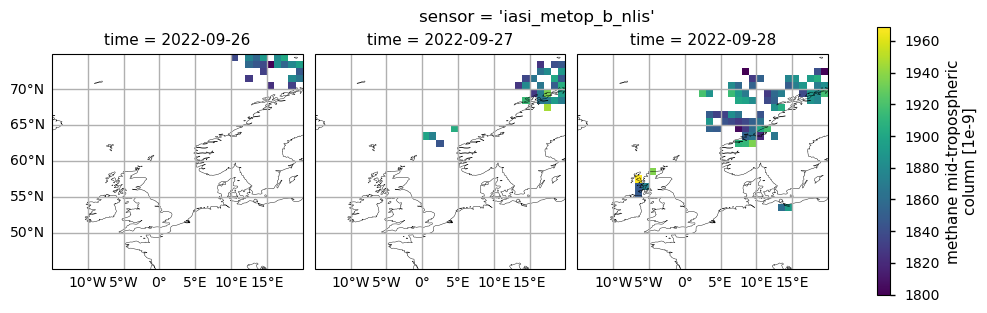

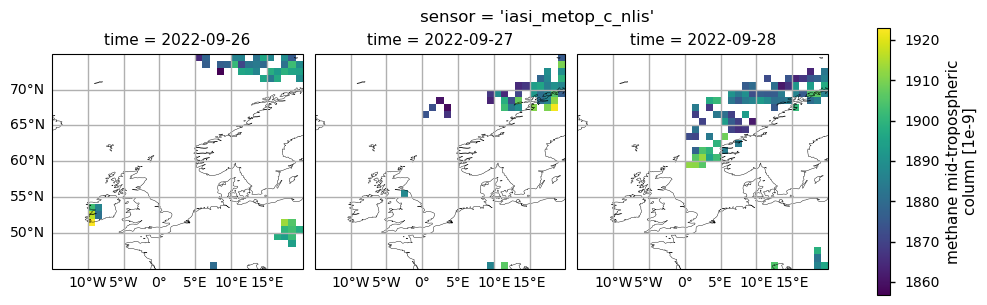

In [20]:
# To plot CH4 data for sensors and selected days
for sensor, ds_sensor in ds.groupby("sensor"):
        # Select days of interest
        ds_sensor_filtered = ds_sensor.sel(time=selected_days)
        plot.projected_map(ds_sensor_filtered["ch4"], col="time", col_wrap=3)
        plt.suptitle(f"{sensor = }", y=1)
        plt.show()

*The figure shows mid-tropospheric CH$_4$ (expressed in ppb) for 26-28 September 2022 as provided by the IASI-B (upper plots) and IASI-C (lower plots) datasets (v10.2).*

#### Spatial and temporal analysis of cloud cover
To attribute differences in the data availability between mid-tropospheric CH$_4$ data from Climate Data Store and that reported by [[3]](https://doi.org/10.5194/acp-24-10639-2024), we inspected the daily values of cloud cover fraction provided by the Interim Climate Data Record [[6]](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview) "Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations" (product family: CLARA-A3). 

It is clear that the the presence of high values of cloud cover fraction over the most part of the observation scene prevented the detection of the Nord Stream plume on 26 -  27 September 202 by the Climate Data Store IASI mid-tropospheric CH$_4$ dataset. According to the Documentation [[7]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_E_latest.pdf), the Climate Data Store mid-tropospheric satellite IASI CH4 (v10.2) dataset is retrieved when no cloud or aerosol is detected. On the other hand, for the dataset used by [[3]](https://doi.org/10.5194/acp-24-10639-2024), only scenes strongly affected by clouds are not processed [[8]](https://doi.org/10.5281/zenodo.5873645).

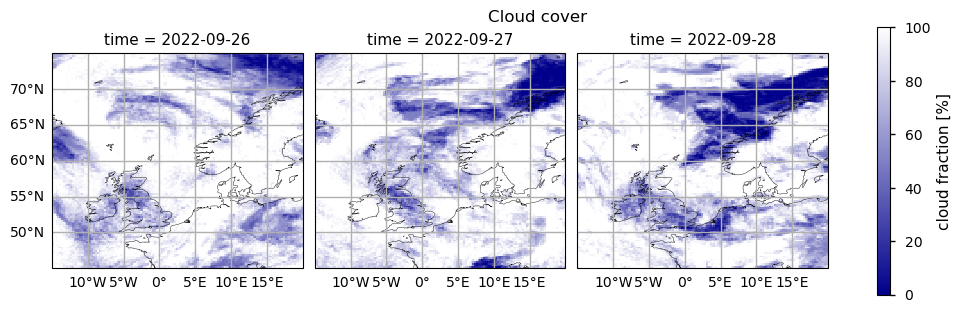

In [21]:
# Colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "white"])

# Filter data for selected days
ds_cloud_filtered = ds_cloud.sel(time=selected_days)

# Setting plot view
plot_kwargs = {"col": "time", "col_wrap": 3}

# Plotting cloud cover data
plot.projected_map(ds_cloud_filtered[varname_cloud], cmap=cmap, **plot_kwargs)
_ = plt.suptitle("Cloud cover", y=1)

plt.show()

*The figure shows the total cloud coverage fraction (espressed as %) for 26-28 September 2022 as provided by the Climate Data Store Interim Climate Data Record “Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations” (product family: CLARA-A3)*

#### Analysis of the altitude sensitivity of the retrieved mid-tropospheric CH4

The vertical sensitivity of the IASI CH$_4$ mid-tropospheric product may affect the identification and the quantification of the plume from the Nord Stream pipelines. The averaging kernel (AK), which is provided as variable in the Climate Data Store data, accounts for the vertical sensitivity of the derived CH$_4$ values from the IASI retrievals, as described in [[7]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_E_latest.pdf). 

For the Climate Data Store mid-tropospheric CH$_4$ product, the normalised column AK values averaged over the spatial domain showed a maximum sensitivity in the mid-upper troposphere (from 100 to 600 hPa) during the time period considered. According to [[3]] (https://doi.org/10.5194/acp-24-10639-2024), the southern part of the Nord Stream plume [59-63° N; 0-7° E], extending from the west coast of Scandinavia, was diffuse above 500 hPa, favouring the plume detection by the Climate Data Store mid-tropospheric CH$_4$ IASI data products. 

Users interested in further information on the use of the AKs (as an example for comparison with model simulations) are encouraged to consult the dataset documentation [[9]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_E_latest.pdf) and [[5]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf).   

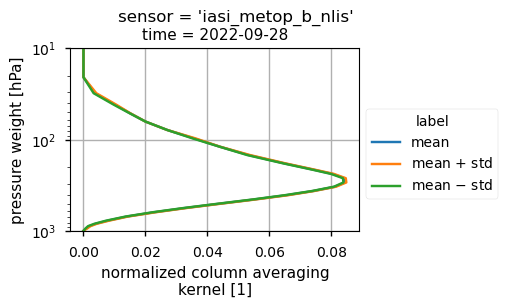

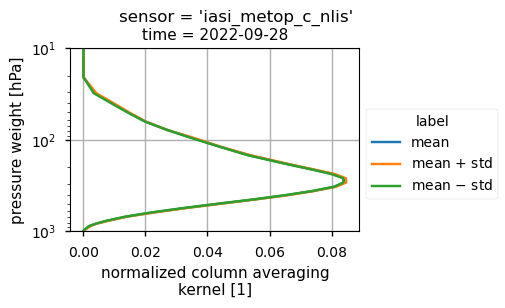

In [22]:
# Setting plot view
plot_kwargs = {"col": "time", "col_wrap": 1}

for sensor, da_sensor in ds[vertical_profile].groupby("sensor"):
    da_mean = diagnostics.spatial_weighted_mean(da_sensor)
    da_std = diagnostics.spatial_weighted_std(da_sensor)
    da = xr.concat(
        [
            da_mean.expand_dims(label=["mean"]),
            (da_mean + da_std).expand_dims(label=["mean $+$ std"]),
            (da_mean - da_std).expand_dims(label=["mean $-$ std"]),
        ],
        "label",
    )
    da_filtered = da.sel(time=selected_days_AK)
    facet = da_filtered.plot(
        y="pressure_weight",
        hue="label",
        yscale="log",
        yincrease=False,
        ylim=(1000, 10),  # Limit y axis to 1
        **plot_kwargs,
    )
    for ax in facet.axs.flatten():
        ax.grid()
    plt.suptitle(f"{sensor = }", y=1.01)
    plt.show()

*IASI-B (top plot) and IASI-C (bottom plot) for CH$_4$ normalised column averaging kernel computed over the analysed region on 28 September 2022.*

#### Temporal variability of mid-tropospheric CH$_4$ over the region

As clearly stated in the dataset Documentation [[5]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf), the dataset "Methane data from 2002 to present derived from satellite observations" should be used them in combination with appropriate modelling to obtain information on surface CH$_4$ fluxes. 

To illustrate that the use of this dataset without appropriate modelling can lead to misleading conclusions, we analysed the temporal variability of the mid-tropospheric CH$_4$ column over the study region. In particular, we calculated the distribution of CH$_4$ values for each single day during September 2022 for both IASI-B and IASI-C. The box and wiskers plot shows the percentiles of the data distribution, the median (green line) as well as the outliers. 
It can be seen that despite the occurrence of the Nord Stream leak and the effective detection of the plume signal by IASI-C on 29 September 2022, the CH$_4$ values did not deviate from the monthly variability. This shows that even if the atmospheric data provided by the mid-tropospheric IASI CH$_4$ (v10.2) dataset contain the signal of the CH$_4$ release from the Nord Stream pipelines, it can hardly be detected without the use of appropriate modelling, as adopted by [[3]](https://doi.org/10.5194/acp-24-10639-2024) or [[10]](https://climate.copernicus.eu/esotc/2023/greenhouse-gas-fluxes).  

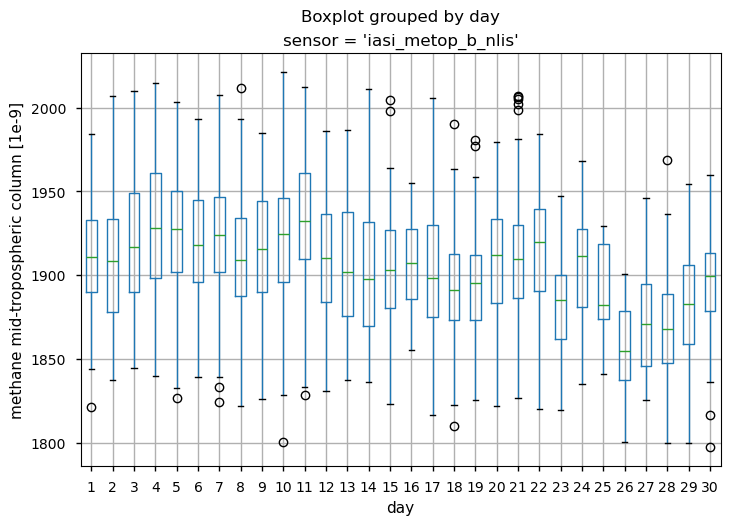

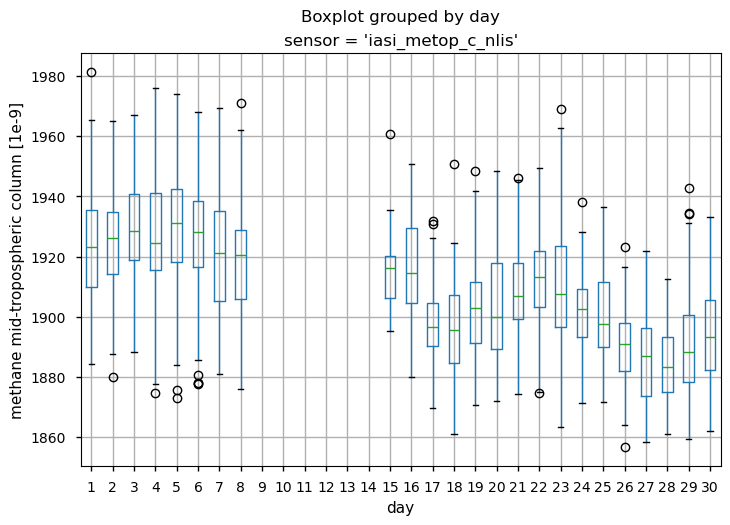

In [10]:
for sensor, ds_sensor in ds.groupby("sensor"):
    da_sensor = ds_sensor["ch4"].squeeze()
    df_sensor = (
        da_sensor.stack(location=("latitude", "longitude"))
        .drop_vars("location")
        .to_dataframe()
    )
    df_sensor = df_sensor.reset_index()[["time", "ch4"]]
    df_sensor["day"] = df_sensor["time"].dt.day
    ax = df_sensor[["day", "ch4"]].boxplot(by="day")
    ax.set_title(f"{sensor = }")
    ax.set_xlabel("day")
    ax.set_ylabel(f"{da_sensor.long_name} [{da_sensor.units}]")
    plt.show()

*Daily percentiles and outliers for mid-tropospheric CH4 (expressed in ppb) during September 2022 as provided by the IASI-B (upper plots) and IASI-C (lower plots) datasets (v10.2).*

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Methane data from 2002 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-methane?tab=overview
* Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview

More information on the Nord Stream leak event can be found in [[4]](https://www.unep.org/news-and-stories/story/pipeline-blasts-released-record-shattering-amount-methane-unep-study).

Users interested in near-ral time detection of hot-spot locations for methane emissions can consider to use the CAMS Methane Hotspot Explorer [[11]](https://atmosphere.copernicus.eu/ghg-services/cams-methane-hotspot-explorer?utm_source=press&utm_medium=referral&utm_campaign=CH4-app-2025).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

https://www.unep.org/news-and-stories/story/pipeline-blasts-released-record-shattering-amount-methane-unep-study

### References
[[1]](https://wmo.int/publication-series/wmo-greenhouse-gas-bulletin-no-19) World Meteorological Organization (2023). WMO Greenhouse Gas Bulletin, No. 19, ISSN 2078-0796.

[[2]](https://doi.org/10.1073/pnas.0600201103) West, J. J., Fiore, A. M., Horowitz, L. W., and Mauzerall, D. L. (2006). Global health benefits of mitigating ozone pollution with methane emission controls. P. Natl. Acad. Sci. USA, 103, 3988–3993. 

[[3]](https://doi.org/10.5194/acp-24-10639-2024) Wilson, C., Kerridge, B. J., Siddans, R., Moore, D. P., Ventress, L. J., Dowd, E., Feng, W., Chipperfield, M. P., and Remedios, J. J. (2024). Quantifying large methane emissions from the Nord Stream pipeline gas leak of September 2022 using IASI satellite observations and inverse modelling. Atmos. Chem. Phys., 24, 10639–10653.   

[[4]](https://www.unep.org/news-and-stories/story/pipeline-blasts-released-record-shattering-amount-methane-unep-study) United Nations Environmental Programme (UNEP), (2025). Pipeline blasts released record-shattering amount of methane: UNEP study. https://www.unep.org/news-and-stories/story/pipeline-blasts-released-record-shattering-amount-methane-unep-study

[[5]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) Buchwitz, M. (2024). Product User Guide and Specification (PUGS) – Main document for Greenhouse Gas (GHG: CO2 & CH4) data set CDR7 (01.2003-12.2022). 

[[6]](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview) Copernicus Climate Change Service (C3S), Climate Data Store (CDS). (2022). Cloud properties global gridded monthly and daily data from 1982 to present derived from satellite observations. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.68653055 (Accessed on 19-Mar-2025). 

[[7]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_ATBD_GHG_E_latest.pdf) Crevoisier, C. (2024). Algorithm Theoretical Basis Document (ATBD) – ANNEX E for IASI CO2 (v10.1) and CH4 (v10.2) and AIRS CO2 mid-tropospheric products.

[[8]](https://doi.org/10.5281/zenodo.5873645). Ventress, L., Siddans, R., Knappett, D. (2021). RAL IASI Methane Retrieval (ATDB).  

[[9]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_E_latest.pdf) Crevoisier, C. (2023). Product User Guide and Specification (PUGS) – ANNEX E for IASI CO2 (10.1) and CH4 (v10.2) and AIRS CO2 mid-tropospheric products.

[[10]](https://climate.copernicus.eu/esotc/2023/greenhouse-gas-fluxes) Copernicus Climate Change Service (C3S). (2024). European State of the Climate 2023, Web site.

[[11]](https://atmosphere.copernicus.eu/ghg-services/cams-methane-hotspot-explorer?utm_source=press&utm_medium=referral&utm_campaign=CH4-app-2025) Copernicus Atmosphere Monitoring Service (CAMS). (2025). Copernicus: Tool to routinely identify and track methane emissions and leaks goes operational, Web site.